In [41]:
import cv2
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt

In [45]:
# Load YOLO model and test image
model = YOLO('model.pt')
test_image = cv2.imread('image.png')

In [46]:
# Function for prediction

def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    return results

def predict_and_detect(chosen_model, img, classes=[], conf=0.5, rectangle_thickness=2, text_thickness=1):
    results = predict(chosen_model, img, classes, conf=conf)
    for result in results:
        for box in result.boxes:
            cv2.rectangle(img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                          (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (255, 0, 0), rectangle_thickness)
            cv2.putText(img, f"{result.names[int(box.cls[0])]}",
                        (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), text_thickness)
    return img, results

In [47]:
# Run detection on the image
result_img, results = predict_and_detect(model, test_image, classes=[], conf=0.25)


0: 640x384 2 titles-or-authorss, 68.4ms
Speed: 1.7ms preprocess, 68.4ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 384)


In [48]:
# Save and display output image with bounding boxes
cv2.imwrite('image_output.jpg',result_img)

True

Extracted Text: DONNA, TARTT, THE, SECRET, HISTORY


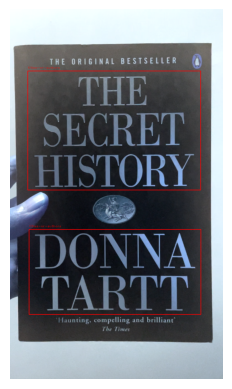

In [52]:
# OCR Setup and Processing
reader = easyocr.Reader(['en'])

output_text = ""
def run_ocr_on_boxes(image, boxes):
    ocr_results = []
    
    for box in boxes:
        # Extract bounding box details
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        
        # Crop and run OCR
        cropped_image = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = reader.readtext(cropped_image)
        
        ocr_results.append({
            'box': (x1, y1, x2, y2),
            'ocr_result': ocr_result
        })
    
    return ocr_results

# Run OCR on detected objects
for result in results:
    orig_img = result.orig_img
    ocr_results = run_ocr_on_boxes(orig_img, result.boxes)

    # Extract and print the text from OCR results
    extracted_text = [detection[1] for ocr_result in ocr_results for detection in ocr_result['ocr_result']]
    output_text = ', '.join(extracted_text)
    print(f"Extracted Text: {output_text}")

    # Optionally visualize bounding boxes
    plt.imshow(orig_img)
    plt.axis('off')
    plt.show()

In [53]:
output_text

'DONNA, TARTT, THE, SECRET, HISTORY'

In [54]:
import ollama
prompt = f"""
        - Below is a text extracted from an OCR. The text contains mentions of famous books and their corresponding authors.
        - Some words may be slightly misspelled or out of order.
        - Your task is to identify the book titles and corresponding authors from the text.
        - Output the text in the format: '<Name of the book> : <Name of the author>'.
        - Do not generate any other text except the book title and the author.
        
        TEXT:
        {output_text}
"""
# Call the LLaMA 3 model
response = ollama.chat(
    model="llama3",
    messages=[{"role": "user", "content": prompt}]
)
# Extract the response content
response_text = response['message']['content'].strip()
print(response_text)


The Secret History : Donna Tartt
